<a href="https://colab.research.google.com/github/Hydra1War/letter-recognition/blob/main/main_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
%matplotlib inline

In [ ]:
cp /content/drive/MyDrive/archwords1/archwords1.zip /content/

In [ ]:
!unzip -q /content/archwords1.zip

In [ ]:
# не выполнять если уже все библиотеки скинуты и распакованы!!!!!!!!!!!!!!!!!!!
# А то все крашнется и не будет работать
import shutil 
from tqdm import tqdm
import os

data_root = '/content/archwords1/train'
train_dir = 'train/'
test_dir = 'test/'


class_names = ['а', 'б', 'в', 'г', 'д', 'е', 'йо', 'ж', 'з', 'и', 'ие', 'к', 'л',
               'м', 'н', 'о', 'п', 'р', 'с', 'т','у', 'ф', 'х', 'ч', 'ш', 'щ',
               'ъ' ,'ы', 'ь', 'э', 'ю', 'я']


for dir_name in [train_dir, test_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(test_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 410/410 [00:00<00:00, 8696.64it/s]


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    #torchvision.transforms.RandomRotation(30),
    #torchvision.transforms.RandomVerticalFlip(p=0.5),
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.GaussianBlur(kernel_size=23),
    #torchvision.transforms.RandomErasing(p=0.5, scale=(0.02, 0.03), ratio=(0.3, 0.3), value=0, inplace=False),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(test_dir, val_transforms)

batch_size = 64
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

NameError: ignored

In [ ]:
len(train_dataloader), len(train_dataset)

(171, 10883)

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
        #print(epoch_loss)
    return model

In [ ]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, loss, optimizer, scheduler, num_epochs=60);

Epoch 0/59:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)

  8%|▊         | 14/171 [03:16<07:05,  2.71s/it]

KeyboardInterrupt: ignored

In [ ]:
!mkdir /content/model/

In [ ]:
torch.save(model, "/content/model/model.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


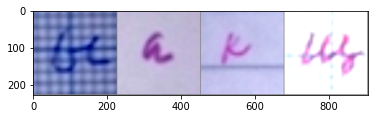

    ы     а     к     щ


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(val_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4,:,:,:]))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))